In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
titer_file = '../data/katzelnick2015/processed/normalized_titers.csv'
tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'

colors = pickle.load(open('../figures/colors.p', 'rb'))
out_path = './png'

In [3]:
titers = pd.read_csv(titer_file, sep=',', index_col=0)
titers = titers.groupby(['virus', 'sera'])['autologous_log2titer'].agg('mean').reset_index()
titers = titers.pivot(index='virus', columns='sera', values='autologous_log2titer')

tree = bt.loadJSON(tree_file, {'name': 'strain', 'height': 'xvalue'})


Tree height: 0.335580
Tree length: 7.088900
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [4]:
genotype_tree = bt.loadNexus('../frequencies/source/annotated_tree.nexus', absoluteTime=False)
genotype_lookup = { k.traits['clade'] : k.traits['genotype'] for k in genotype_tree.Objects if k.branchType=='leaf' and 'genotype' in k.traits and 'SYLVATIC' not in k.traits['genotype']}

In [5]:
def find_distances(k1, k2, tree):
    '''Finds trace between tip and vaccine_tip, 
    sums dTiter along all branches along the path, 
    and returns this distance.'''
    
    assert k1 in tree.Objects and k2 in tree.Objects
    
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    dTiter = sum([k.traits['dTiter'] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2    
    genetic_distance = sum([k.length for k in total_trace])
    homotypic = k1.traits['strain'][:5] == k2.traits['strain'][:5]
    
    try:
        virus_gt = genotype_lookup[k1.traits['clade']]
    except:
        virus_gt = None
    try:
        serum_gt = genotype_lookup[k2.traits['clade']]
    except:
        serum_gt = None
    return {'antigenic': dTiter, 'genetic': genetic_distance, 'homotypic': homotypic, 'virus_genotype': virus_gt, 'serum_genotype': serum_gt}

# try:
#     distances = pd.read_csv(out_path+'tip_distances.csv', index_col=0)
# except:
clade_lookup = { k.traits['strain'] : k for k in tree.Objects if k.branchType=='leaf'}
distances = []
missing = []
for virus in titers.index.values:
    for serum in titers.columns.values:
        try:
            v = clade_lookup[virus]
        except KeyError:
            missing.append(virus)
            continue
        try:
            s = clade_lookup[serum]
        except KeyError:
            missing.append(serum)
            continue
        distances.append(find_distances(v, s, tree))

distances = pd.DataFrame(distances)
distances.to_csv(out_path+'tip_distances.csv')

In [6]:
def plot_geno_pheno(df, ax):
    c = [ colors['all_effects'] if i==True else colors['interserotype_effects'] for i in df['homotypic'].values]
    sns.regplot('genetic', 'antigenic', data=df, 
                scatter_kws={'color': c, 'alpha': 0.1}, 
                line_kws={'color': 'lightgray'},
                ax=ax)
    ax.set_xlabel('Genetic distance (substitutions / site)')
    ax.set_ylabel('Antigenic distance (log2(titers))')

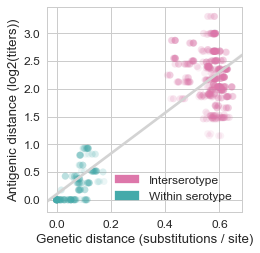

In [7]:
sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(7.5/2,7.5/2))

plot_geno_pheno(distances, ax)

interserotype_label = mpatches.Patch(color=colors['interserotype_effects'], label='Interserotype')
intraserotype_label = mpatches.Patch(color=colors['all_effects'], label='Within serotype')
plt.legend(handles=[interserotype_label, intraserotype_label])

plt.tight_layout()
plt.savefig('./png/genetic_antigenic_distance.png', dpi=300, bbox_inches='tight')
plt.show()

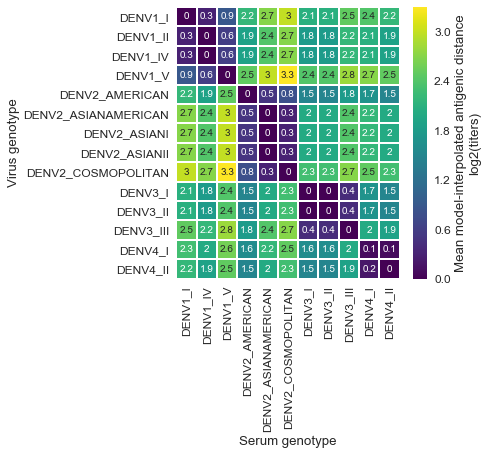

In [8]:
# def plot_genotype_Dij(df):
    
fig, ax = plt.subplots(figsize=(5,5))
gt_distances = distances.groupby(['virus_genotype', 'serum_genotype'])['antigenic'].agg('mean')
gt_distances = gt_distances.reset_index().pivot(columns='serum_genotype', index='virus_genotype')
gt_distances = pd.DataFrame({ k[1]: v for k,v in gt_distances.to_dict().items()}).round(1)
ax = sns.heatmap(gt_distances, cmap=colors['cmap'], annot=True,annot_kws={'fontsize': 10}, 
                 linewidths=1, cbar_kws={'label': 'Mean model-interpolated antigenic distance\nlog2(titers)'})
ax.set_xlabel('Serum genotype')
ax.set_ylabel('Virus genotype')

plt.savefig(out_path+'genotype_dTiter_heatmap.png', dpi=300, bbox_inches='tight')